# ANALYSE DES OPINIONS SOUS TWITTER

Audrey Quessada  
INF344

In [1]:
%matplotlib inline
import os
import csv as csv
import nltk as nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from IPython.display import display, HTML
from nltk.corpus import wordnet as wn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sentiwordnet import SentiWordNetCorpusReader, SentiSynset

In [2]:
csvTweetData = 'testdata.manual.2009.06.14.csv'

In [3]:
colonne = ['Notes_tweet','Index','Date','Subject','Author','Tweet']
df1 = pd.read_csv(csvTweetData, sep=',', header=None)
df1.columns = colonne
N, _ = df1.shape
print("Il y a %d tweets" %N)
print(display(df1.iloc[0:10]))

Il y a 498 tweets


,Notes_tweet,Index,Date,Subject,Author,Tweet
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
5,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...
6,0,9,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non lo...
7,4,10,Mon May 11 03:26:10 UTC 2009,jquery,dcostalis,Jquery is my new best friend.
8,4,11,Mon May 11 03:27:15 UTC 2009,twitter,PJ_King,Loves twitter
9,4,12,Mon May 11 03:29:20 UTC 2009,obama,mandanicole,how can you not love Obama? he makes jokes abo...


None


## 1.1Pre-processing simple des tweets

Import du dictionnaire abréviation (http://perso.telecom-paristech.fr/~clavel/DonneesTweets/SlangLookupTable.txt)  
Le  fichier text est converti en dictionnaire python où pour chaque abréviation en clé correspond sa traduction en valeur.

In [4]:
f = open('./dico_slang.txt')
slanglines = f.readlines()     
f.close()

In [5]:
list_slang = [x.replace('\t',' ').replace('\n','') for x in slanglines]
#print(list_slang[0].split())
#print(list_slang)
slang = [l.split()[0] for l in list_slang if l]
translate_slang = [' '.join(l.split()[1:]) for l in list_slang if l]
dico_slang = {}
for i,j in zip(slang,translate_slang):
    dico_slang[i] = j
print(dico_slang)

{'wfm': 'works for me', 'ru': 'are you', 'ttyl': 'talk to you later', 'thx': 'thanks', 'w/': 'with', 'gf': 'girlfriend', 'h8': 'hate', 'wibni': "wouldn't it be nice if", 'w/o': 'without', 'bak': 'back at the keyboard', 'fud': 'fear, uncertainty, and doubt', 'b4n': 'bye for now', 'idk': "I don't know", 'f*ck': 'fuck', 'g2g': 'got to go', 'u': 'you', 'btw': 'by the way', 'cul8r': 'see you later', 'ur': 'you are', 'ic': 'I see', 'l8r': 'later', 'shid': 'slaps head in disgust', 'bff': 'best friends forever', 'dbau': 'doing business as usual', 'omg': 'oh my god', 'iow': 'in other words', 'pir': 'parent in room', 'gal': 'get a life', 'adn': 'any day now', 'lmao': 'laugh my ass off', 'wtg': 'way to go', 'wb': 'welcome back', 'nooooooo': 'no', 'loooooooovvvvvveee': 'love', 'sh*t': 'shit', 'gfn': 'gone for now', 'g': 'grin', 'co-o': 'cooperate', 'rpg': 'role playing games', 'bf': 'boyfriend', 'imao': 'in my arrogant opinion', 'cya': 'bye', 'lulas': 'love you like a sister', 'irl': 'in real life

Extraction des destinataires, des urls, des hashtags et nettoyages des tweets:  
On crée un dictionnaire qui va contenir les adresses url, les destinataires des tweets et les hashtags répertoriés.  
Pour cela on va utiliser plusieurs regex nous permettant de récupérer ces informations.  
On va aussi "nettoyer" les tweets, à savoir, une fois qu'on a enlever les champs sus-mentionnés, on met tous les tweets en minuscule et on enlève la ponctuation ou certains caractères spéciaux.  
Il faut enlever RT qui veut dire retweet (ou on peut compter le nombre de retweet)  
On va tester dans un premier temps les regex

In [6]:
test0 = "Blah, blah, blah same old same old. No plans today, going back to sleep I guess."
test1 = 'Nike owns NBA Playoffs ads w/ LeBron, Kobe, Carmelo? http://ow.ly/7Uiy  #Adidas #Billups #Howard  #Marketing #Branding'
test2 = '@phyreman9 Google is always a good place to look. Should\'ve mentioned I worked on the Mustang w/ my Dad, @KimbleT.'
test3 = 'Life?s a bitch? and so is Dick Cheney. #p2 #bipart #tlot #tcot #hhrs #GOP #DNC http://is.gd/DjyQ'
test4 = '@anna_debenham what was the php jquery hack?'
test5 = '@ work til 6pm... lets go lakers!!!'
test6 = "RT @PassionModel 'American Idol' fashion: Adam Lambert tones down, Danny Gokey cute ... http://cli.gs/7JWSHV"
test7 = "RT @justindavey: RT @tweetmeme GM OnStar now instantly sends accident location coordinates to 911 | GPS Obsessed http://bit.ly/16szL1"
test8 = 'RT @shrop: Awesome JQuery reference book for Coda! http://www.macpeeps.com/coda/ #webdesign'
test9 = "Time Warner Cable Pulls the Plug on 'The Girlfriend Experience' - (www.tinyurl.com/m595fk)"
test10 = 'House Correspondents dinner was last night whoopi, barbara &amp; sherri went, Obama got a standing ovation'
test11 = "I'm listening to 'P.Y.T' by Danny Gokey &lt;3 &lt;3 &lt;3 Aww, he's so amazing. I &lt;3 him so much :)"


On va écrire des fonctions qui vont permettre de nettoyer les tweets

In [7]:
def get_url(string):
    '''fonction qui permet de trouver tous les liens, qui prend en entrée une chaine de caractères
    retourne en sortie la liste des url et la chaine de caractères nettoyée de l url'''
    reg1 = re.findall("http\S+",string)
    reg2 = re.findall('([\da-z\.-]+)(\.[a-z\.]{2,6}\/\w+)', string)
    if reg1:
        return ''.join(reg1[0]), re.sub("http\S+", '',string)
    elif reg2:
        return ''.join(reg2[0]), re.sub('([\da-z\.-]+)(\.[a-z\.]{2,6}\/\w+)','', string)
    else:
        return [], string

In [8]:
print(get_url(test6))
print(' ')
print(get_url(test9))
print(' ')
print(get_url(test0))

('http://cli.gs/7JWSHV', "RT @PassionModel 'American Idol' fashion: Adam Lambert tones down, Danny Gokey cute ... ")
 
('www.tinyurl.com/m595fk', "Time Warner Cable Pulls the Plug on 'The Girlfriend Experience' - ()")
 
([], 'Blah, blah, blah same old same old. No plans today, going back to sleep I guess.')


In [9]:
def get_hashtag(string):
    reg = re.findall('#(\w+)', string)
    if reg:
        return reg, re.sub('#(\w+)','', string, flags = re.UNICODE)
    else:
        return [], string

In [10]:
print(get_hashtag(test1))
print(' ')
print(get_hashtag(test0))

(['Adidas', 'Billups', 'Howard', 'Marketing', 'Branding'], 'Nike owns NBA Playoffs ads w/ LeBron, Kobe, Carmelo? http://ow.ly/7Uiy       ')
 
([], 'Blah, blah, blah same old same old. No plans today, going back to sleep I guess.')


In [11]:
def get_at(string):
    reg = re.findall('@(\w+)', string)
    if reg:
        return reg, re.sub('@','', string, flags = re.UNICODE)
    else:
        return [], string

In [12]:
print(get_at(test2))
print(' ')
print(get_at(test0))
print(' ')
print(get_at(test5))

(['phyreman9', 'KimbleT'], "phyreman9 Google is always a good place to look. Should've mentioned I worked on the Mustang w/ my Dad, KimbleT.")
 
([], 'Blah, blah, blah same old same old. No plans today, going back to sleep I guess.')
 
([], '@ work til 6pm... lets go lakers!!!')


In [13]:
def get_retweet(string):
    reg = re.findall('RT', string)
    if reg:
        return reg, re.sub('RT','', string)
    else:
        return [], string

In [14]:
print(get_retweet(test7))
print(' ')
print(get_retweet(test0))

(['RT', 'RT'], ' @justindavey:  @tweetmeme GM OnStar now instantly sends accident location coordinates to 911 | GPS Obsessed http://bit.ly/16szL1')
 
([], 'Blah, blah, blah same old same old. No plans today, going back to sleep I guess.')


In [15]:
def get_tweet_cleant(string):
    reg1 = re.findall('&amp;', string)
    reg2 = re.findall('&gt;', string)
    reg3 = re.findall('&lt;3', string)
    if reg1:
        t = re.sub('&amp;',' and ',string)
        return re.sub("[','|'_'|';'|','|'!'|'?'|'...'|'\'|':'|'='|'+'|'('|')'|'$']", ' ',t)
    elif reg2:
        t = re.sub('&gt;',' greater than ',string)
        return re.sub("[','|'_'|';'|','|'!'|'?'|'...'|'\'|':'|'='|'+'|'('|')'|'$']", ' ',t)
    elif reg3:
        t = re.sub('&lt;3',' love ',string)
        return re.sub("[','|'_'|';'|','|'!'|'?'|'...'|'\'|':'|'='|'+'|'('|')'|'$']", ' ',t)
    else:
        return re.sub("[','|'_'|';'|','|'!'|'?'|'...'|'\'|':'|'='|'+'|'('|')'|'$']", ' ',string)
    

In [16]:
print(get_tweet_cleant(test10))
print(' ')
print(get_tweet_cleant(test6))
print(' ')
print(get_tweet_cleant(test4))
print(' ')
print(get_tweet_cleant(test11))

House Correspondents dinner was last night whoopi  barbara  and  sherri went  Obama got a standing ovation
 
RT @PassionModel  American Idol  fashion  Adam Lambert tones down  Danny Gokey cute     http //cli gs/7JWSHV
 
@anna debenham what was the php jquery hack 
 
I m listening to  P Y T  by Danny Gokey  love   love   love  Aww  he s so amazing  I  love  him so much   


In [17]:
def apply_clean_listv1(list_tweet, hashtag=True, RT=True, destinataire=True, url=True, punct=True):
    dico_tweet = {}
    at_per_tweet = []#destinataire
    hash_per_tweet = []#hashtag
    url_per_tweet = []#url
    list_destinataire = []
    list_hashtag = []
    list_RT = []
    list_url = []
    clean_tweet = []
    
    for tweet in list_tweet:
        if RT == True:
            rt, tweet = get_retweet(tweet)
            list_RT.extend(rt)
        else:
            pass
        
        if destinataire == True: 
            at, tweet = get_at(tweet)
            list_destinataire.extend(at)
            at_per_tweet.append(at)
        else:
            pass
        
        if hashtag == True:
            hasht, tweet = get_hashtag(tweet)
            hash_per_tweet.append(hasht)
            list_hashtag.extend(hasht)
        else:
            pass
        
        if url == True:  
            ur, tweet = get_url(tweet)
            list_url.extend(ur)
            url_per_tweet.append(ur)
        else:
            pass
        
        if punct == True:
            tweet = get_tweet_cleant(tweet)
        else:
            pass
        
        clean_tweet.append(tweet)

    dico_tweet['Destinataire'] = at_per_tweet
    dico_tweet['hashtag'] = hash_per_tweet
    dico_tweet['url'] = url_per_tweet
    
    n_hashtag = len(list_hashtag)
    n_destinataire = len(list_destinataire)
    n_retweet = len(list_RT)
    n_url = len(list_url)
    
    return n_url, n_hashtag, n_destinataire, n_retweet, dico_tweet, clean_tweet


In [18]:
n_url, n_hashtag, n_destinataire, n_retweet, dico_tweet, clean_tweet = apply_clean_listv1(df1['Tweet'], hashtag=True, RT=True, destinataire=True, url=True, punct=True)
print('Nombre d\'url: ', n_url)
print('Nombre de hashtags: ', n_hashtag)
print('Nombre de destinataires: ', n_destinataire)
print('Nombre de retweet: ', n_retweet)
print(' ')
print(clean_tweet)

Nombre d'url:  2929
Nombre de hashtags:  51
Nombre de destinataires:  124
Nombre de retweet:  21
 
['stellargirl I loooooooovvvvvveee my Kindle2  Not that the DX is cool  but the 2 is fantastic in its own right ', 'Reading my kindle2     Love it    Lee childs is good read ', 'Ok  first assesment of the     it fucking rocks   ', 'kenburbary You ll love your Kindle2  I ve had mine for a few months and never looked back  The new big one is huge  No need for remorse    ', 'mikefish  Fair enough  But i have the Kindle2 and I think it s perfect    ', 'richardebaker no  it is too big  I m quite happy with the Kindle2 ', 'Fuck this economy  I hate aig and their non loan given asses ', 'Jquery is my new best friend ', 'Loves twitter', 'how can you not love Obama  he makes jokes about himself ', 'Check this video out -- President Obama at the White House Correspondents  Dinner ', 'Karoli I firmly believe that Obama/Pelosi have ZERO desire to be civil   It s a charade and a slogan  but they want 

In [19]:
df2 = pd.DataFrame.from_dict(dico_tweet, orient='columns')
print(display(df2.iloc[0:40]))

,Destinataire,hashtag,url
0,[stellargirl],[],[]
1,[],[],[]
2,[],[kindle2],[]
3,[kenburbary],[],[]
4,[mikefish],[],[]
5,[richardebaker],[],[]
6,[],[],[]
7,[],[],[]
8,[],[],[]
9,[],[],[]


None


In [20]:
def get_token_from_tweet(list_tweet, lower=True):
    tkn = nltk.word_tokenize
    if lower == True:
        return [tkn(x.lower()) for x in list_tweet]
    else:
        return [tkn(x) for x in list_tweet]


In [21]:
words = get_token_from_tweet(clean_tweet, lower=False)
print(words)

[['stellargirl', 'I', 'loooooooovvvvvveee', 'my', 'Kindle2', 'Not', 'that', 'the', 'DX', 'is', 'cool', 'but', 'the', '2', 'is', 'fantastic', 'in', 'its', 'own', 'right'], ['Reading', 'my', 'kindle2', 'Love', 'it', 'Lee', 'childs', 'is', 'good', 'read'], ['Ok', 'first', 'assesment', 'of', 'the', 'it', 'fucking', 'rocks'], ['kenburbary', 'You', 'll', 'love', 'your', 'Kindle2', 'I', 've', 'had', 'mine', 'for', 'a', 'few', 'months', 'and', 'never', 'looked', 'back', 'The', 'new', 'big', 'one', 'is', 'huge', 'No', 'need', 'for', 'remorse'], ['mikefish', 'Fair', 'enough', 'But', 'i', 'have', 'the', 'Kindle2', 'and', 'I', 'think', 'it', 's', 'perfect'], ['richardebaker', 'no', 'it', 'is', 'too', 'big', 'I', 'm', 'quite', 'happy', 'with', 'the', 'Kindle2'], ['Fuck', 'this', 'economy', 'I', 'hate', 'aig', 'and', 'their', 'non', 'loan', 'given', 'asses'], ['Jquery', 'is', 'my', 'new', 'best', 'friend'], ['Loves', 'twitter'], ['how', 'can', 'you', 'not', 'love', 'Obama', 'he', 'makes', 'jokes', '

On nettoie la liste des token en enlevant les slangs

In [22]:
def clean_from_dico(list_tweet, dico, lower=True):
    if lower == True:
        word = get_token_from_tweet(clean_tweet, lower=True)
    else:
        word = get_token_from_tweet(clean_tweet, lower=False)
    words_noslang = []
    for i in range(len(word)):
        for k,v in dico.items():       
            for n, w in enumerate(word[i]):
                if w.lower() == k:
                    word[i][n] = v
        words_noslang.append(word[i]) 
    return words_noslang

In [23]:
words_noslang = clean_from_dico(clean_tweet, dico_slang, lower=False)
print(words_noslang)            


[['stellargirl', 'I', 'love', 'my', 'Kindle2', 'Not', 'that', 'the', 'DX', 'is', 'cool', 'but', 'the', '2', 'is', 'fantastic', 'in', 'its', 'own', 'right'], ['Reading', 'my', 'kindle2', 'Love', 'it', 'Lee', 'childs', 'is', 'good', 'read'], ['Ok', 'first', 'assesment', 'of', 'the', 'it', 'fucking', 'rocks'], ['kenburbary', 'You', 'll', 'love', 'your', 'Kindle2', 'I', 've', 'had', 'mine', 'for', 'a', 'few', 'months', 'and', 'never', 'looked', 'back', 'The', 'new', 'big', 'one', 'is', 'huge', 'No', 'need', 'for', 'remorse'], ['mikefish', 'Fair', 'enough', 'But', 'i', 'have', 'the', 'Kindle2', 'and', 'I', 'think', 'it', 's', 'perfect'], ['richardebaker', 'no', 'it', 'is', 'too', 'big', 'I', 'm', 'quite', 'happy', 'with', 'the', 'Kindle2'], ['Fuck', 'this', 'economy', 'I', 'hate', 'aig', 'and', 'their', 'non', 'loan', 'given', 'asses'], ['Jquery', 'is', 'my', 'new', 'best', 'friend'], ['Loves', 'twitter'], ['how', 'can', 'you', 'not', 'love', 'Obama', 'he', 'makes', 'jokes', 'about', 'himse

In [24]:
df1['clean_tweet'] = [' '.join(words_noslang[i]) for i in range(len(words_noslang))]
df1['tokens'] = words_noslang
print(display(df1.iloc[0:20]))

,Notes_tweet,Index,Date,Subject,Author,Tweet,clean_tweet,tokens
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,stellargirl I love my Kindle2 Not that the DX ...,"[stellargirl, I, love, my, Kindle2, Not, that,..."
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,Reading my kindle2 Love it Lee childs is good ...,"[Reading, my, kindle2, Love, it, Lee, childs, ..."
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...",Ok first assesment of the it fucking rocks,"[Ok, first, assesment, of, the, it, fucking, r..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...,kenburbary You ll love your Kindle2 I ve had m...,"[kenburbary, You, ll, love, your, Kindle2, I, ..."
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...,mikefish Fair enough But i have the Kindle2 an...,"[mikefish, Fair, enough, But, i, have, the, Ki..."
5,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...,richardebaker no it is too big I m quite happy...,"[richardebaker, no, it, is, too, big, I, m, qu..."
6,0,9,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non lo...,Fuck this economy I hate aig and their non loa...,"[Fuck, this, economy, I, hate, aig, and, their..."
7,4,10,Mon May 11 03:26:10 UTC 2009,jquery,dcostalis,Jquery is my new best friend.,Jquery is my new best friend,"[Jquery, is, my, new, best, friend]"
8,4,11,Mon May 11 03:27:15 UTC 2009,twitter,PJ_King,Loves twitter,Loves twitter,"[Loves, twitter]"
9,4,12,Mon May 11 03:29:20 UTC 2009,obama,mandanicole,how can you not love Obama? he makes jokes abo...,how can you not love Obama he makes jokes abou...,"[how, can, you, not, love, Obama, he, makes, j..."


None


Etiquetage grammatical:  
on construit un dictionnaire pour chaque tweet contenant tous les POS-tags

In [25]:
tag = nltk.pos_tag
def getPOS(list_token):
    all_tag = []
    for i in range(len(list_token)):
        all_tag.append(tag(list_token[i]))
    return all_tag

In [26]:
tag_list_tot = getPOS(words_noslang)
df1['POS'] = tag_list_tot
print(display(df1.iloc[0:20]))

,Notes_tweet,Index,Date,Subject,Author,Tweet,clean_tweet,tokens,POS
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,stellargirl I love my Kindle2 Not that the DX ...,"[stellargirl, I, love, my, Kindle2, Not, that,...","[(stellargirl, NN), (I, PRP), (love, VBP), (my..."
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,Reading my kindle2 Love it Lee childs is good ...,"[Reading, my, kindle2, Love, it, Lee, childs, ...","[(Reading, VBG), (my, PRP$), (kindle2, NN), (L..."
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...",Ok first assesment of the it fucking rocks,"[Ok, first, assesment, of, the, it, fucking, r...","[(Ok, NNP), (first, JJ), (assesment, NN), (of,..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...,kenburbary You ll love your Kindle2 I ve had m...,"[kenburbary, You, ll, love, your, Kindle2, I, ...","[(kenburbary, NN), (You, PRP), (ll, VBP), (lov..."
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...,mikefish Fair enough But i have the Kindle2 an...,"[mikefish, Fair, enough, But, i, have, the, Ki...","[(mikefish, JJ), (Fair, NNP), (enough, RB), (B..."
5,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...,richardebaker no it is too big I m quite happy...,"[richardebaker, no, it, is, too, big, I, m, qu...","[(richardebaker, NN), (no, DT), (it, PRP), (is..."
6,0,9,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non lo...,Fuck this economy I hate aig and their non loa...,"[Fuck, this, economy, I, hate, aig, and, their...","[(Fuck, NNP), (this, DT), (economy, NN), (I, P..."
7,4,10,Mon May 11 03:26:10 UTC 2009,jquery,dcostalis,Jquery is my new best friend.,Jquery is my new best friend,"[Jquery, is, my, new, best, friend]","[(Jquery, NN), (is, VBZ), (my, PRP$), (new, JJ..."
8,4,11,Mon May 11 03:27:15 UTC 2009,twitter,PJ_King,Loves twitter,Loves twitter,"[Loves, twitter]","[(Loves, NNS), (twitter, NN)]"
9,4,12,Mon May 11 03:29:20 UTC 2009,obama,mandanicole,how can you not love Obama? he makes jokes abo...,how can you not love Obama he makes jokes abou...,"[how, can, you, not, love, Obama, he, makes, j...","[(how, WRB), (can, MD), (you, PRP), (not, RB),..."


None


Les verbes sont repérés par les tags VB, VBZ , VBP, VBN, VBD, MD 

In [27]:
def get_verbs(list_tag):
    tot_pos = []
    for i in range (len(list_tag)):
        for j in range (len(list_tag[i])):
            tot_pos.append(list_tag[i][j][1])
    count_VB = Counter(tot_pos)
    verb_tag = ['VB', 'VBZ' , 'VBP', 'VBG', 'VBN', 'VBD','MD']
    sum_vb = 0
    for k,v in  count_VB.items():
        if k in verb_tag:
            sum_vb += v
    return sum_vb, count_VB


In [28]:
sum_vb, count_VB = get_verbs(tag_list_tot)
print(count_VB)
print(' ')
print('Le nombre total de POS verbes sur l\'ensemble des tweets est: ', sum_vb)

Counter({'NNP': 1305, 'NN': 1118, 'IN': 579, 'DT': 435, 'JJ': 434, 'PRP': 373, 'RB': 327, 'VBP': 253, 'VB': 234, 'NNS': 228, 'VBZ': 194, 'VBD': 185, 'VBG': 179, 'CC': 159, 'TO': 147, 'CD': 110, 'PRP$': 105, 'VBN': 76, 'MD': 49, ':': 49, 'RP': 34, 'JJR': 32, 'WRB': 28, 'JJS': 23, '``': 22, 'WP': 16, "''": 12, 'NNPS': 8, 'WDT': 7, 'EX': 7, 'PDT': 6, 'SYM': 6, 'RBR': 5, 'UH': 2, 'FW': 1, '#': 1, 'WP$': 1, 'POS': 1, '$': 1})
 
Le nombre total de POS verbes sur l'ensemble des tweets est:  1170


## 1.2 Algorithme de détection v1 : appel au dictionnaire Sentiwordnet

In [29]:
wn.synsets('dog')

[Synset('dog.n.01'),
 Synset('frump.n.01'),
 Synset('dog.n.03'),
 Synset('cad.n.01'),
 Synset('frank.n.02'),
 Synset('pawl.n.01'),
 Synset('andiron.n.01'),
 Synset('chase.v.01')]

In [30]:
swn_filename = './SentiWordNet_3.0.0_20130122.txt'
swn = SentiWordNetCorpusReader(swn_filename)
test = swn.senti_synset('breakdown.n.03')
print('test d\'un mot: ', test.synset.name)
print('score positif: ', test.pos_score)
print('score negatif: ', test.neg_score)

test d'un mot:  <bound method Synset.name of Synset('breakdown.n.03')>
score positif:  0.0
score negatif:  0.25


In [31]:
noun_tag = ['NN','NNS','NNP','NNPS']
adj_tag = ['JJ','JJR','JJS']
adv_tag = ['RB','RBR','RBS']
v_tag = ['VB', 'VBZ' , 'VBP', 'VBG', 'VBN', 'VBD']
all_tag = ['NN','NNS','NNP','NNPS', 'JJ','JJR','JJS','RB','RBR','RBS', 'VB', 'VBZ' , 'VBP', 'VBG', 'VBN', 'VBD']

On récupère les POS-tags valides à savoir ceux qui correspondent aux noms, adjectifs, verbes, et adverbes.

In [32]:
def wordnet_sanitize(word):
    """
    author:christopher potts
    http://compprag.christopherpotts.net/wordnet.html
    Ensure that word is a (string, pos) pair that WordNet can understand.
 
    Argument: word (str, str) -- a (string, pos) pair
 
    Value: a possibly modified (string, pos) pair, where pos=None if
    the input pos is outside of WordNet.
    """
    string, tag = word
    string = string.lower()
    tag = tag.lower()
    if tag.startswith('v'):    tag = 'v'
    elif tag.startswith('n'):  tag = 'n'
    elif tag.startswith('j'):  tag = 'a'
    elif tag.startswith('rb'): tag = 'r'
    if tag in ('a', 'n', 'r', 'v'):
        return (string, tag)
    else:
        return (string, None)

In [33]:
def get_score_senti(tag_list):
    tweet_sanitize = []
    pos_score = []
    pos_sum_score = []
    neg_score = []
    neg_sum_score = []
    for ttag in tag_list:
        n = len(ttag)
        new_san = [wordnet_sanitize(ttag[i]) for i in range(n) if ttag[i][1] in all_tag]
        tweet_sanitize.append(new_san)
    for tweet in tweet_sanitize:
        pos_tweet = []
        neg_tweet = []
        for i in range(len(tweet)):
            w, t = tweet[i]
            tweet_senti = list(swn.senti_synsets(w,t))
            if tweet_senti:
                senti = list(swn.senti_synsets(w,t))[0]
                pos_tweet.append(senti.pos_score)
                neg_tweet.append(senti.neg_score)
        pos_score.append(pos_tweet)       
        neg_score.append(neg_tweet)
        pos_sum_score.append(sum(pos_tweet))
        neg_sum_score.append(sum(neg_tweet))
    return tweet_sanitize, pos_score, pos_sum_score, neg_score, neg_sum_score


In [34]:
tweet_sanitize, pos_score, pos_sum_score, neg_score, neg_sum_score = get_score_senti(tag_list_tot)
print(tweet_sanitize[0])

[('stellargirl', 'n'), ('love', 'v'), ('kindle2', 'n'), ('not', 'r'), ('dx', 'n'), ('is', 'v'), ('cool', 'a'), ('is', 'v'), ('fantastic', 'a'), ('own', 'a'), ('right', 'n')]


In [35]:
print('Score positif des 10 premiers tweets')
print(pos_sum_score[:10])  
print('')
print('Score négatif des 10 premiers tweets')
print(neg_sum_score[:10])

Score positif des 10 premiers tweets
[1.25, 1.75, 0.375, 1.875, 1.0, 1.5, 0.0, 1.5, 0.625, 0.875]

Score négatif des 10 premiers tweets
[1.0, 0.125, 0.125, 1.875, 0.125, 1.125, 0.875, 0.125, 0.0, 0.625]


In [36]:
df1['Score_Pos'] = pos_sum_score
df1['Score_Neg'] = neg_sum_score
note_global = []
for p,n in zip(pos_sum_score, neg_sum_score):
    if p > n:
        note_global.append(1)
    elif p == n:
        note_global.append(0)
    else:
        note_global.append(-1)
df1['Note_globale'] = note_global
print(display(df1.iloc[0:20]))

,Notes_tweet,Index,Date,Subject,Author,Tweet,clean_tweet,tokens,POS,Score_Pos,Score_Neg,Note_globale
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,stellargirl I love my Kindle2 Not that the DX ...,"[stellargirl, I, love, my, Kindle2, Not, that,...","[(stellargirl, NN), (I, PRP), (love, VBP), (my...",1.250,1.000,1
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,Reading my kindle2 Love it Lee childs is good ...,"[Reading, my, kindle2, Love, it, Lee, childs, ...","[(Reading, VBG), (my, PRP$), (kindle2, NN), (L...",1.750,0.125,1
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...",Ok first assesment of the it fucking rocks,"[Ok, first, assesment, of, the, it, fucking, r...","[(Ok, NNP), (first, JJ), (assesment, NN), (of,...",0.375,0.125,1
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...,kenburbary You ll love your Kindle2 I ve had m...,"[kenburbary, You, ll, love, your, Kindle2, I, ...","[(kenburbary, NN), (You, PRP), (ll, VBP), (lov...",1.875,1.875,0
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...,mikefish Fair enough But i have the Kindle2 an...,"[mikefish, Fair, enough, But, i, have, the, Ki...","[(mikefish, JJ), (Fair, NNP), (enough, RB), (B...",1.000,0.125,1
5,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...,richardebaker no it is too big I m quite happy...,"[richardebaker, no, it, is, too, big, I, m, qu...","[(richardebaker, NN), (no, DT), (it, PRP), (is...",1.500,1.125,1
6,0,9,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non lo...,Fuck this economy I hate aig and their non loa...,"[Fuck, this, economy, I, hate, aig, and, their...","[(Fuck, NNP), (this, DT), (economy, NN), (I, P...",0.000,0.875,-1
7,4,10,Mon May 11 03:26:10 UTC 2009,jquery,dcostalis,Jquery is my new best friend.,Jquery is my new best friend,"[Jquery, is, my, new, best, friend]","[(Jquery, NN), (is, VBZ), (my, PRP$), (new, JJ...",1.500,0.125,1
8,4,11,Mon May 11 03:27:15 UTC 2009,twitter,PJ_King,Loves twitter,Loves twitter,"[Loves, twitter]","[(Loves, NNS), (twitter, NN)]",0.625,0.000,1
9,4,12,Mon May 11 03:29:20 UTC 2009,obama,mandanicole,how can you not love Obama? he makes jokes abo...,how can you not love Obama he makes jokes abou...,"[how, can, you, not, love, Obama, he, makes, j...","[(how, WRB), (can, MD), (you, PRP), (not, RB),...",0.875,0.625,1


None


On récupère les notes des tweets: on donne 1 pour 4, 0 pour 2 et-1 pour 0

In [37]:
df1['Notes_tweet'] = df1['Notes_tweet'].replace(0,-1).replace(2,0).replace(4,1)
print(display(df1.iloc[0:20]))

,Notes_tweet,Index,Date,Subject,Author,Tweet,clean_tweet,tokens,POS,Score_Pos,Score_Neg,Note_globale
0,1,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,stellargirl I love my Kindle2 Not that the DX ...,"[stellargirl, I, love, my, Kindle2, Not, that,...","[(stellargirl, NN), (I, PRP), (love, VBP), (my...",1.250,1.000,1
1,1,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,Reading my kindle2 Love it Lee childs is good ...,"[Reading, my, kindle2, Love, it, Lee, childs, ...","[(Reading, VBG), (my, PRP$), (kindle2, NN), (L...",1.750,0.125,1
2,1,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...",Ok first assesment of the it fucking rocks,"[Ok, first, assesment, of, the, it, fucking, r...","[(Ok, NNP), (first, JJ), (assesment, NN), (of,...",0.375,0.125,1
3,1,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...,kenburbary You ll love your Kindle2 I ve had m...,"[kenburbary, You, ll, love, your, Kindle2, I, ...","[(kenburbary, NN), (You, PRP), (ll, VBP), (lov...",1.875,1.875,0
4,1,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...,mikefish Fair enough But i have the Kindle2 an...,"[mikefish, Fair, enough, But, i, have, the, Ki...","[(mikefish, JJ), (Fair, NNP), (enough, RB), (B...",1.000,0.125,1
5,1,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...,richardebaker no it is too big I m quite happy...,"[richardebaker, no, it, is, too, big, I, m, qu...","[(richardebaker, NN), (no, DT), (it, PRP), (is...",1.500,1.125,1
6,-1,9,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non lo...,Fuck this economy I hate aig and their non loa...,"[Fuck, this, economy, I, hate, aig, and, their...","[(Fuck, NNP), (this, DT), (economy, NN), (I, P...",0.000,0.875,-1
7,1,10,Mon May 11 03:26:10 UTC 2009,jquery,dcostalis,Jquery is my new best friend.,Jquery is my new best friend,"[Jquery, is, my, new, best, friend]","[(Jquery, NN), (is, VBZ), (my, PRP$), (new, JJ...",1.500,0.125,1
8,1,11,Mon May 11 03:27:15 UTC 2009,twitter,PJ_King,Loves twitter,Loves twitter,"[Loves, twitter]","[(Loves, NNS), (twitter, NN)]",0.625,0.000,1
9,1,12,Mon May 11 03:29:20 UTC 2009,obama,mandanicole,how can you not love Obama? he makes jokes abo...,how can you not love Obama he makes jokes abou...,"[how, can, you, not, love, Obama, he, makes, j...","[(how, WRB), (can, MD), (you, PRP), (not, RB),...",0.875,0.625,1


None


In [38]:
n_positif = sum(df1['Notes_tweet']==1)
n_neutre = sum(df1['Notes_tweet']==0)
n_negatif = sum(df1['Notes_tweet']==-1)
print('le nombre de tweets positifs vrais est: ', n_positif)
print(' ')
print('le nombre de tweets neutres vrais est: ', n_neutre)
print(' ')
print('le nombre de tweets négatifs vrais est: ', n_negatif)

le nombre de tweets positifs vrais est:  182
 
le nombre de tweets neutres vrais est:  139
 
le nombre de tweets négatifs vrais est:  177


On teste le score de prédiction:

In [39]:
y_true = np.array(df1['Notes_tweet'])
y_pred = np.array(df1['Note_globale']) 
print(classification_report(y_true,y_pred))

             precision    recall  f1-score   support

         -1       0.67      0.44      0.53       177
          0       0.49      0.36      0.41       139
          1       0.47      0.73      0.57       182

avg / total       0.55      0.52      0.51       498



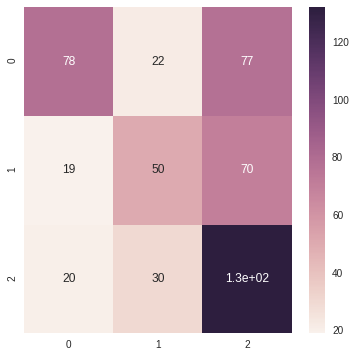

In [40]:
conf_matrix_meth01 = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix_meth01, annot=True)

In [41]:
list_tweet_pos_correct = [y_pred[i] for i in range(len(y_pred)) if (y_pred[i]==1 and y_pred[i]*y_true[i]==1)]
print('le nombre de tweets positifs prédits correctement: ',len(list_tweet_pos_correct))


le nombre de tweets positifs prédits correctement:  132


In [42]:
list_tweet_neg_correct = [y_pred[i] for i in range(len(y_pred)) if (y_pred[i]==-1 and y_pred[i]*y_true[i]==1)]
print('le nombre de tweets negatifs prédits correctement: ',len(list_tweet_neg_correct))


le nombre de tweets negatifs prédits correctement:  78


In [43]:
print('le nombre de tweets mal prédits est:', N - sum(y_pred==y_true))

le nombre de tweets mal prédits est: 238


## 1.3 Algorithme de détection v2 : gestion de la négation et des modifieurs

In [44]:
f = open('./BoosterWordList.txt')
boosterlines = f.readlines()     
f.close()

In [45]:
list_booster = [x.replace('\t',' ').replace('\n','') for x in boosterlines]
booster = [l.split()[0] for l in list_booster if l]
score_booster = [' '.join(l.split()[1:]) for l in list_booster if l]
dico_booster = {}
for i,j in zip(booster,score_booster):
    dico_booster[i] = j
print(dico_booster)

{'absolutely': '1', 'overwhelmingly': '2', 'fuckin': '2', 'definitely': '1', 'very': '1', 'so': '0 Was 1 but sometimes used as neutral or mild term', 'furkin': '2', 'some': '-1', 'just': '-1', 'extremely': '2', 'incredibly': '2', 'fucking': '2', 'sum': '-1', 'hugely': '2'}


In [46]:
f = open('./NegatingWordList.txt')
negatinglines = f.readlines()     
f.close()

In [47]:
list_negating = [x.replace('\n','') for x in negatinglines]
print(list_negating)

["aren't", 'arent', "ain't", "can't", 'cannot', 'cant', "don't", 'dont', "isn't", 'isnt', 'never', 'not', "won't", 'wont', "wouldn't", 'wouldnt']


In [48]:
def get_score_with_neg_mod(tweet):
    new_score_pos = []
    new_score_neg = []
    n = len(tweet)
    if n > 1:
        for i in range (1,n):
            score_pos, score_neg =0,0
            w,t = tweet[i]
            w_1 = tweet[i-1][0]
            tweet_senti = list(swn.senti_synsets(w,t))
            if tweet_senti:
                senti = list(swn.senti_synsets(w,t))[0]
                if w_1 in booster:
                    score_pos = 2*senti.pos_score
                    score_neg = 2*senti.neg_score
                elif w_1 in list_negating:
                    score_pos = senti.neg_score
                    score_neg = senti.pos_score
                else:
                    score_pos = senti.pos_score
                    score_neg = senti.neg_score
            new_score_pos.append(score_pos)
            new_score_neg.append(score_neg)
    return new_score_pos, new_score_neg, sum(new_score_pos), sum(new_score_neg)

In [49]:
corr_pos_score1 = []
corr_neg_score1 = []
corr_pos_glob_score1 = []
corr_neg_glob_score1 = []
for t in (tweet_sanitize):
    tweet_pos, tweet_neg, tweet_pos_score, tweet_neg_score = get_score_with_neg_mod(t)
    corr_pos_score1.append(tweet_pos)
    corr_neg_score1.append(tweet_neg)
    corr_pos_glob_score1.append(tweet_pos_score)
    corr_neg_glob_score1.append(tweet_neg_score)
print('Score positif global des 10 premiers tweets: ', corr_pos_glob_score1[:10])
print('Score negatif global des 10 premiers tweets: ', corr_neg_glob_score1[:10])


Score positif global des 10 premiers tweets:  [1.25, 1.75, 0.375, 1.875, 1.0, 1.5, 0.0, 1.5, 0.0, 0.375]
Score negatif global des 10 premiers tweets:  [1.0, 0.125, 0.125, 1.875, 0.125, 1.125, 0.875, 0.125, 0.0, 0.5]


In [50]:
df1['Score_Pos_v2'] = corr_pos_glob_score1
df1['Score_Neg_v2'] = corr_neg_glob_score1
note_global1 = []
for p,n in zip(corr_pos_glob_score1, corr_neg_glob_score1):
    if p > n:
        note_global1.append(1)
    elif p == n:
        note_global1.append(0)
    else:
        note_global1.append(-1)
df1['Note_globale_v2'] = note_global1
print(display(df1.iloc[0:20]))

,Notes_tweet,Index,Date,Subject,Author,Tweet,clean_tweet,tokens,POS,Score_Pos,Score_Neg,Note_globale,Score_Pos_v2,Score_Neg_v2,Note_globale_v2
0,1,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,stellargirl I love my Kindle2 Not that the DX ...,"[stellargirl, I, love, my, Kindle2, Not, that,...","[(stellargirl, NN), (I, PRP), (love, VBP), (my...",1.250,1.000,1,1.250,1.000,1
1,1,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,Reading my kindle2 Love it Lee childs is good ...,"[Reading, my, kindle2, Love, it, Lee, childs, ...","[(Reading, VBG), (my, PRP$), (kindle2, NN), (L...",1.750,0.125,1,1.750,0.125,1
2,1,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...",Ok first assesment of the it fucking rocks,"[Ok, first, assesment, of, the, it, fucking, r...","[(Ok, NNP), (first, JJ), (assesment, NN), (of,...",0.375,0.125,1,0.375,0.125,1
3,1,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...,kenburbary You ll love your Kindle2 I ve had m...,"[kenburbary, You, ll, love, your, Kindle2, I, ...","[(kenburbary, NN), (You, PRP), (ll, VBP), (lov...",1.875,1.875,0,1.875,1.875,0
4,1,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...,mikefish Fair enough But i have the Kindle2 an...,"[mikefish, Fair, enough, But, i, have, the, Ki...","[(mikefish, JJ), (Fair, NNP), (enough, RB), (B...",1.000,0.125,1,1.000,0.125,1
5,1,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...,richardebaker no it is too big I m quite happy...,"[richardebaker, no, it, is, too, big, I, m, qu...","[(richardebaker, NN), (no, DT), (it, PRP), (is...",1.500,1.125,1,1.500,1.125,1
6,-1,9,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non lo...,Fuck this economy I hate aig and their non loa...,"[Fuck, this, economy, I, hate, aig, and, their...","[(Fuck, NNP), (this, DT), (economy, NN), (I, P...",0.000,0.875,-1,0.000,0.875,-1
7,1,10,Mon May 11 03:26:10 UTC 2009,jquery,dcostalis,Jquery is my new best friend.,Jquery is my new best friend,"[Jquery, is, my, new, best, friend]","[(Jquery, NN), (is, VBZ), (my, PRP$), (new, JJ...",1.500,0.125,1,1.500,0.125,1
8,1,11,Mon May 11 03:27:15 UTC 2009,twitter,PJ_King,Loves twitter,Loves twitter,"[Loves, twitter]","[(Loves, NNS), (twitter, NN)]",0.625,0.000,1,0.000,0.000,0
9,1,12,Mon May 11 03:29:20 UTC 2009,obama,mandanicole,how can you not love Obama? he makes jokes abo...,how can you not love Obama he makes jokes abou...,"[how, can, you, not, love, Obama, he, makes, j...","[(how, WRB), (can, MD), (you, PRP), (not, RB),...",0.875,0.625,1,0.375,0.500,-1


None


In [51]:
y_pred1 = np.array(df1['Note_globale_v2']) 
print(classification_report(y_true,y_pred1))

             precision    recall  f1-score   support

         -1       0.62      0.40      0.49       177
          0       0.51      0.45      0.48       139
          1       0.48      0.68      0.56       182

avg / total       0.54      0.52      0.51       498



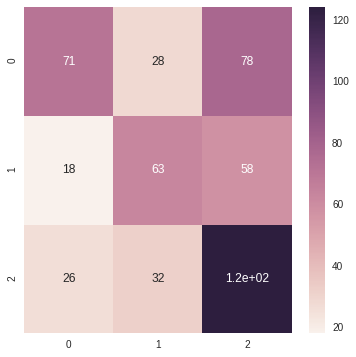

In [52]:
conf_matrix_meth02 = confusion_matrix(y_true, y_pred1)
fig = plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix_meth02, annot=True)

In [53]:
list_tweet_pos_correct2 = [y_pred1[i] for i in range(len(y_pred1)) if (y_pred1[i]==1 and y_pred1[i]*y_true[i]==1)]
print('le nombre de tweets positifs prédits correctement est de: ', len(list_tweet_pos_correct2))

le nombre de tweets positifs prédits correctement est de:  124


In [54]:
list_tweet_neg_correct2 = [y_pred1[i] for i in range(len(y_pred1)) if (y_pred1[i]==-1 and y_pred1[i]*y_true[i]==1)]
print('le nombre de tweets negatifs prédits correctement est de: ', len(list_tweet_neg_correct2))


le nombre de tweets negatifs prédits correctement est de:  71


Le nombre de tweets positifs prédits correctement avec cette méthode est de 124

In [55]:
print('le nombre de tweets mal prédits est:', N - sum(y_pred1==y_true))

le nombre de tweets mal prédits est: 240


Avec cette méthode on gère moins bien la prédiction des tweets positifs

## 1.4 Algorithme de détection v3 : gestion des emoticons

In [56]:
df3 = df1[['Notes_tweet','Index','Date','Subject','Author', 'Tweet']]

In [57]:
f = open('./EmoticonLookupTable.txt')
emoticonlines = f.readlines()     
f.close()

In [58]:
list_emoticon = [x.replace('\t','MM').replace('\n','') for x in emoticonlines]
emoticon = []
value_emoticon = []
list_emoticon = [l.split('MM') for l in list_emoticon if l]
for e,t in list_emoticon:
    emoticon.append(e)
    value_emoticon.append(int(t))

dico_emoticon = {}
for i,j in zip(emoticon,value_emoticon):
    dico_emoticon[i] = j
print(dico_emoticon)

{'<3': 1, ':-D': 1, '--^--@': 1, ':-*': 1, ':[': -1, 'XP': 1, '>:O': -1, '(^.^)': 1, ':-}': 1, ':-\\': 0, '8)': 1, ':]': 1, 'XO': -1, ':-(': -1, ":'-(": -1, '>:D': 1, 'x3?': 1, ':-/': 0, ':-O': 0, '>:)': 1, '8-)': 0, '8\\': -1, '8-0': -1, '%-(': -1, ':9': 1, '*\\o/*': 1, ':,(': -1, ':)': 1, ':(': -1, 'xP': -1, '>:L': -1, '):': -1, ':*(': -1, ":'(": -1, ':-|': -1, '(^_^)': 1, ':s': -1, '@}->--': 1, 'D:': -1, ':S': -1, '*)': 0, ':X': 1, ':#': -1, '|D': 1, '>:(': -1, 'X-(': -1, '(^-^)': 1, '^o)': -1, ':-&': -1, '</3-1': -1, '0:)': 1, 'xD': 1, ':E': -1, ':l': 0, ':o(': -1, '|8c': -1, ':-P': 1, ':-S': -1, ':b)': 1, '(o;': 0, '(-:': 1, ':?': 1, '38*': -1, 'Bc': -1, '=(': -1, '^_^': 1, 'X(': -1, ';o)': 0, '>/': -1, '>\\': -1, ';^)': 1, 'B(': -1, ':\\': -1, '8/': -1, ':?(': -1, '>=D': 1, ')-:': -1, ':o)': 1, '(:': 1, '=]': 1, ':O': -1, '=[': -1, ':p': 1, 'XD': 1, ':|': 0, ':F': -1, '>o>': -1, '(o:': 1, ':_(': -1, ':P': 1, ':3': 1, '}:)': 1, ':D': 1, '=)': 1, '%-)': 1, ':-(o)': -1, ')o:': -1, '

In [59]:
list_tweet2 = df3['Tweet']
n_url2, n_hashtag2, n_destinataire2, n_retweet2, dico_tweet2, clean_tweet2 = apply_clean_listv1(list_tweet2, hashtag=True, RT=True, destinataire=True, url=True, punct=False)
print(clean_tweet2)

['stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.', 'Reading my kindle2...  Love it... Lee childs is good read.', 'Ok, first assesment of the  ...it fucking rocks!!!', "kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)", "mikefish  Fair enough. But i have the Kindle2 and I think it's perfect  :)", "richardebaker no. it is too big. I'm quite happy with the Kindle2.", 'Fuck this economy. I hate aig and their non loan given asses.', 'Jquery is my new best friend.', 'Loves twitter', 'how can you not love Obama? he makes jokes about himself.', "Check this video out -- President Obama at the White House Correspondents' Dinner ", "Karoli I firmly believe that Obama/Pelosi have ZERO desire to be civil.  It's a charade and a slogan, but they want to destroy conservatism", 'House Correspondents dinner was last night whoopi, barbara &amp; sherri 

In [60]:
tweet_no_emoji = []
table_index = []
score_initial = []
for ind, tweet in zip(df3['Index'],clean_tweet2):
    for k,v in dico_emoticon.items():
        if k in tweet:
            t = tweet.replace(k,' ')
            tweet_no_emoji.append(t)
            table_index.append(ind)
            score_initial.append(v)
            
print(tweet_no_emoji)  
print(' ')
print(score_initial)
print(' ')
print(table_index)

["kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse!  ", "mikefish  Fair enough. But i have the Kindle2 and I think it's perfect   ", 'omg so bored &amp; my tattoooos are so itchy!!  help! aha  ', 'I\'m listening to "P.Y.T" by Danny Gokey &lt;3 &lt;3 &lt;3 Aww, he\'s so amazing. I &lt;3 him so much  ', 'I\'m listening to "P.Y.T" by Danny Gokey       Aww, he\'s so amazing. I   him so much :)', 'is going to sleep then on a bike ride ', 'Hello Twitter API  ', ' SmartChickPDX: Was just told that Nike layoffs started today  ', 'Back when I worked for Nike we had one fav word : JUST DO IT!  ', 'Class... The 50d is supposed to come today  ', 'needs someone to explain lambda calculus to him!  ', 'insects have infected my spinach plant  ', 'omgg i ohhdee want mcdonalds damn i wonder if its open lol  ', "I hate revision, it's so boring! I am totally unprepared for my exam tomorrow   Things are not looking good.

In [61]:
total_tweet = []
total_score_init = []
i = 0
for ind, tweet in zip(df3['Index'],clean_tweet2):
    if ind not in table_index:
        total_tweet.append(tweet)
        total_score_init.append(0)
    else:
        total_tweet.append(tweet_no_emoji[i])
        total_score_init.append(score_initial[i])
        i += 1


In [62]:
df3['Tweet_no_emoji'] = total_tweet
df3['score_no_emoji'] = total_score_init
print(display(df3.iloc[:10]))

/home/audrey/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/audrey/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Notes_tweet,Index,Date,Subject,Author,Tweet,Tweet_no_emoji,score_no_emoji
0,1,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,stellargirl I loooooooovvvvvveee my Kindle2. N...,0
1,1,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,Reading my kindle2... Love it... Lee childs i...,0
2,1,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...","Ok, first assesment of the ...it fucking rock...",0
3,1,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...,kenburbary You'll love your Kindle2. I've had ...,1
4,1,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...,mikefish Fair enough. But i have the Kindle2 ...,1
5,1,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...,richardebaker no. it is too big. I'm quite hap...,0
6,-1,9,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non lo...,Fuck this economy. I hate aig and their non lo...,0
7,1,10,Mon May 11 03:26:10 UTC 2009,jquery,dcostalis,Jquery is my new best friend.,Jquery is my new best friend.,0
8,1,11,Mon May 11 03:27:15 UTC 2009,twitter,PJ_King,Loves twitter,Loves twitter,0
9,1,12,Mon May 11 03:29:20 UTC 2009,obama,mandanicole,how can you not love Obama? he makes jokes abo...,how can you not love Obama? he makes jokes abo...,0


None


In [63]:
_, _, _, _, dico_tweet3, clean_tweet3 = apply_clean_listv1(clean_tweet2, hashtag=False, RT=False, destinataire=False, url=False, punct=True)
print(clean_tweet3)

['stellargirl I loooooooovvvvvveee my Kindle2  Not that the DX is cool  but the 2 is fantastic in its own right ', 'Reading my kindle2     Love it    Lee childs is good read ', 'Ok  first assesment of the     it fucking rocks   ', 'kenburbary You ll love your Kindle2  I ve had mine for a few months and never looked back  The new big one is huge  No need for remorse    ', 'mikefish  Fair enough  But i have the Kindle2 and I think it s perfect    ', 'richardebaker no  it is too big  I m quite happy with the Kindle2 ', 'Fuck this economy  I hate aig and their non loan given asses ', 'Jquery is my new best friend ', 'Loves twitter', 'how can you not love Obama  he makes jokes about himself ', 'Check this video out -- President Obama at the White House Correspondents  Dinner ', 'Karoli I firmly believe that Obama/Pelosi have ZERO desire to be civil   It s a charade and a slogan  but they want to destroy conservatism', 'House Correspondents dinner was last night whoopi  barbara  and  sherri 

In [64]:
wordsnoslang2 = clean_from_dico(clean_tweet3, dico_slang, lower=False)
print(wordsnoslang2)

[['stellargirl', 'I', 'love', 'my', 'Kindle2', 'Not', 'that', 'the', 'DX', 'is', 'cool', 'but', 'the', '2', 'is', 'fantastic', 'in', 'its', 'own', 'right'], ['Reading', 'my', 'kindle2', 'Love', 'it', 'Lee', 'childs', 'is', 'good', 'read'], ['Ok', 'first', 'assesment', 'of', 'the', 'it', 'fucking', 'rocks'], ['kenburbary', 'You', 'll', 'love', 'your', 'Kindle2', 'I', 've', 'had', 'mine', 'for', 'a', 'few', 'months', 'and', 'never', 'looked', 'back', 'The', 'new', 'big', 'one', 'is', 'huge', 'No', 'need', 'for', 'remorse'], ['mikefish', 'Fair', 'enough', 'But', 'i', 'have', 'the', 'Kindle2', 'and', 'I', 'think', 'it', 's', 'perfect'], ['richardebaker', 'no', 'it', 'is', 'too', 'big', 'I', 'm', 'quite', 'happy', 'with', 'the', 'Kindle2'], ['Fuck', 'this', 'economy', 'I', 'hate', 'aig', 'and', 'their', 'non', 'loan', 'given', 'asses'], ['Jquery', 'is', 'my', 'new', 'best', 'friend'], ['Loves', 'twitter'], ['how', 'can', 'you', 'not', 'love', 'Obama', 'he', 'makes', 'jokes', 'about', 'himse

In [65]:
df3['clean_tweet'] = [' '.join(wordsnoslang2 [i]) for i in range(len(wordsnoslang2 ))]
df3['tokens'] = wordsnoslang2 
print(display(df3.iloc[0:20]))

/home/audrey/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/audrey/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Notes_tweet,Index,Date,Subject,Author,Tweet,Tweet_no_emoji,score_no_emoji,clean_tweet,tokens
0,1,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,stellargirl I loooooooovvvvvveee my Kindle2. N...,0,stellargirl I love my Kindle2 Not that the DX ...,"[stellargirl, I, love, my, Kindle2, Not, that,..."
1,1,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,Reading my kindle2... Love it... Lee childs i...,0,Reading my kindle2 Love it Lee childs is good ...,"[Reading, my, kindle2, Love, it, Lee, childs, ..."
2,1,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...","Ok, first assesment of the ...it fucking rock...",0,Ok first assesment of the it fucking rocks,"[Ok, first, assesment, of, the, it, fucking, r..."
3,1,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...,kenburbary You'll love your Kindle2. I've had ...,1,kenburbary You ll love your Kindle2 I ve had m...,"[kenburbary, You, ll, love, your, Kindle2, I, ..."
4,1,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...,mikefish Fair enough. But i have the Kindle2 ...,1,mikefish Fair enough But i have the Kindle2 an...,"[mikefish, Fair, enough, But, i, have, the, Ki..."
5,1,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...,richardebaker no. it is too big. I'm quite hap...,0,richardebaker no it is too big I m quite happy...,"[richardebaker, no, it, is, too, big, I, m, qu..."
6,-1,9,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non lo...,Fuck this economy. I hate aig and their non lo...,0,Fuck this economy I hate aig and their non loa...,"[Fuck, this, economy, I, hate, aig, and, their..."
7,1,10,Mon May 11 03:26:10 UTC 2009,jquery,dcostalis,Jquery is my new best friend.,Jquery is my new best friend.,0,Jquery is my new best friend,"[Jquery, is, my, new, best, friend]"
8,1,11,Mon May 11 03:27:15 UTC 2009,twitter,PJ_King,Loves twitter,Loves twitter,0,Loves twitter,"[Loves, twitter]"
9,1,12,Mon May 11 03:29:20 UTC 2009,obama,mandanicole,how can you not love Obama? he makes jokes abo...,how can you not love Obama? he makes jokes abo...,0,how can you not love Obama he makes jokes abou...,"[how, can, you, not, love, Obama, he, makes, j..."


None


In [66]:
tag_list_tot2 = getPOS(wordsnoslang2)
df3['POS'] = tag_list_tot2
print(display(df3.iloc[0:20]))

/home/audrey/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Notes_tweet,Index,Date,Subject,Author,Tweet,Tweet_no_emoji,score_no_emoji,clean_tweet,tokens,POS
0,1,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,stellargirl I loooooooovvvvvveee my Kindle2. N...,0,stellargirl I love my Kindle2 Not that the DX ...,"[stellargirl, I, love, my, Kindle2, Not, that,...","[(stellargirl, NN), (I, PRP), (love, VBP), (my..."
1,1,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,Reading my kindle2... Love it... Lee childs i...,0,Reading my kindle2 Love it Lee childs is good ...,"[Reading, my, kindle2, Love, it, Lee, childs, ...","[(Reading, VBG), (my, PRP$), (kindle2, NN), (L..."
2,1,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...","Ok, first assesment of the ...it fucking rock...",0,Ok first assesment of the it fucking rocks,"[Ok, first, assesment, of, the, it, fucking, r...","[(Ok, NNP), (first, JJ), (assesment, NN), (of,..."
3,1,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...,kenburbary You'll love your Kindle2. I've had ...,1,kenburbary You ll love your Kindle2 I ve had m...,"[kenburbary, You, ll, love, your, Kindle2, I, ...","[(kenburbary, NN), (You, PRP), (ll, VBP), (lov..."
4,1,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...,mikefish Fair enough. But i have the Kindle2 ...,1,mikefish Fair enough But i have the Kindle2 an...,"[mikefish, Fair, enough, But, i, have, the, Ki...","[(mikefish, JJ), (Fair, NNP), (enough, RB), (B..."
5,1,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...,richardebaker no. it is too big. I'm quite hap...,0,richardebaker no it is too big I m quite happy...,"[richardebaker, no, it, is, too, big, I, m, qu...","[(richardebaker, NN), (no, DT), (it, PRP), (is..."
6,-1,9,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non lo...,Fuck this economy. I hate aig and their non lo...,0,Fuck this economy I hate aig and their non loa...,"[Fuck, this, economy, I, hate, aig, and, their...","[(Fuck, NNP), (this, DT), (economy, NN), (I, P..."
7,1,10,Mon May 11 03:26:10 UTC 2009,jquery,dcostalis,Jquery is my new best friend.,Jquery is my new best friend.,0,Jquery is my new best friend,"[Jquery, is, my, new, best, friend]","[(Jquery, NN), (is, VBZ), (my, PRP$), (new, JJ..."
8,1,11,Mon May 11 03:27:15 UTC 2009,twitter,PJ_King,Loves twitter,Loves twitter,0,Loves twitter,"[Loves, twitter]","[(Loves, NNS), (twitter, NN)]"
9,1,12,Mon May 11 03:29:20 UTC 2009,obama,mandanicole,how can you not love Obama? he makes jokes abo...,how can you not love Obama? he makes jokes abo...,0,how can you not love Obama he makes jokes abou...,"[how, can, you, not, love, Obama, he, makes, j...","[(how, WRB), (can, MD), (you, PRP), (not, RB),..."


None


In [68]:
sum_vb2, count_VB2 = get_verbs(tag_list_tot2)
print(count_VB2)
print(' ')
print('Le nombre total de POS verbes sur l\'ensemble des tweets est: ', sum_vb2)

Counter({'NNP': 1305, 'NN': 1118, 'IN': 579, 'DT': 435, 'JJ': 434, 'PRP': 373, 'RB': 327, 'VBP': 253, 'VB': 234, 'NNS': 228, 'VBZ': 194, 'VBD': 185, 'VBG': 179, 'CC': 159, 'TO': 147, 'CD': 110, 'PRP$': 105, 'VBN': 76, 'MD': 49, ':': 49, 'RP': 34, 'JJR': 32, 'WRB': 28, 'JJS': 23, '``': 22, 'WP': 16, "''": 12, 'NNPS': 8, 'WDT': 7, 'EX': 7, 'PDT': 6, 'SYM': 6, 'RBR': 5, 'UH': 2, 'FW': 1, '#': 1, 'WP$': 1, 'POS': 1, '$': 1})
 
Le nombre total de POS verbes sur l'ensemble des tweets est:  1170


Le fait d'enlever les emojis ne changent pas le nombre de verbes détectés (et c'est tant mieux)

On utilise maintenant sentiword pour donner un score au tweet

In [69]:
tweet_sanitize2, pos_score2, pos_sum_score2, neg_score2, neg_sum_score2 = get_score_senti(tag_list_tot2)
print(tweet_sanitize2[0])

[('stellargirl', 'n'), ('love', 'v'), ('kindle2', 'n'), ('not', 'r'), ('dx', 'n'), ('is', 'v'), ('cool', 'a'), ('is', 'v'), ('fantastic', 'a'), ('own', 'a'), ('right', 'n')]


In [70]:
corr_pos_score2 = []
corr_neg_score2 = []
corr_pos_glob_score2 = []
corr_neg_glob_score2 = []
for t, s in zip(tweet_sanitize2, total_score_init):
    tweet_pos2, tweet_neg2, _, _ = get_score_with_neg_mod(t)
    if s==1:
        tweet_pos2.extend([1.0])
    elif s==-1:
        tweet_neg2.extend([1.0])
    else:
        pass
    corr_pos_score2.append(tweet_pos2)
    corr_neg_score2.append(tweet_neg2)

corr_pos_glob_score2 = [sum(corr_pos_score2[i]) for i in range(len(corr_pos_score2))]
corr_neg_glob_score2 = [sum(corr_neg_score2[i]) for i in range(len(corr_neg_score2))]
print('Score positif global des 10 premiers tweets: ', corr_pos_glob_score2[:10])
print('Score negatif global des 10 premiers tweets: ', corr_neg_glob_score2[:10])

Score positif global des 10 premiers tweets:  [1.25, 1.75, 0.375, 2.875, 2.0, 1.5, 0.0, 1.5, 0.0, 0.375]
Score negatif global des 10 premiers tweets:  [1.0, 0.125, 0.125, 1.875, 0.125, 1.125, 0.875, 0.125, 0.0, 0.5]


In [71]:
df3['Score_Pos_v2'] = corr_pos_glob_score2
df3['Score_Neg_v2'] = corr_neg_glob_score2
note_global2 = []
for p,n in zip(corr_pos_glob_score2, corr_neg_glob_score2):
    if p > n:
        note_global2.append(1)
    elif p == n:
        note_global2.append(0)
    else:
        note_global2.append(-1)
df3['Note_globale_v2'] = note_global2
print(display(df3.iloc[0:20]))

/home/audrey/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/audrey/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/audrey/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

,Notes_tweet,Index,Date,Subject,Author,Tweet,Tweet_no_emoji,score_no_emoji,clean_tweet,tokens,POS,Score_Pos_v2,Score_Neg_v2,Note_globale_v2
0,1,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,stellargirl I loooooooovvvvvveee my Kindle2. N...,0,stellargirl I love my Kindle2 Not that the DX ...,"[stellargirl, I, love, my, Kindle2, Not, that,...","[(stellargirl, NN), (I, PRP), (love, VBP), (my...",1.250,1.000,1
1,1,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,Reading my kindle2... Love it... Lee childs i...,0,Reading my kindle2 Love it Lee childs is good ...,"[Reading, my, kindle2, Love, it, Lee, childs, ...","[(Reading, VBG), (my, PRP$), (kindle2, NN), (L...",1.750,0.125,1
2,1,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...","Ok, first assesment of the ...it fucking rock...",0,Ok first assesment of the it fucking rocks,"[Ok, first, assesment, of, the, it, fucking, r...","[(Ok, NNP), (first, JJ), (assesment, NN), (of,...",0.375,0.125,1
3,1,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...,kenburbary You'll love your Kindle2. I've had ...,1,kenburbary You ll love your Kindle2 I ve had m...,"[kenburbary, You, ll, love, your, Kindle2, I, ...","[(kenburbary, NN), (You, PRP), (ll, VBP), (lov...",2.875,1.875,1
4,1,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...,mikefish Fair enough. But i have the Kindle2 ...,1,mikefish Fair enough But i have the Kindle2 an...,"[mikefish, Fair, enough, But, i, have, the, Ki...","[(mikefish, JJ), (Fair, NNP), (enough, RB), (B...",2.000,0.125,1
5,1,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...,richardebaker no. it is too big. I'm quite hap...,0,richardebaker no it is too big I m quite happy...,"[richardebaker, no, it, is, too, big, I, m, qu...","[(richardebaker, NN), (no, DT), (it, PRP), (is...",1.500,1.125,1
6,-1,9,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non lo...,Fuck this economy. I hate aig and their non lo...,0,Fuck this economy I hate aig and their non loa...,"[Fuck, this, economy, I, hate, aig, and, their...","[(Fuck, NNP), (this, DT), (economy, NN), (I, P...",0.000,0.875,-1
7,1,10,Mon May 11 03:26:10 UTC 2009,jquery,dcostalis,Jquery is my new best friend.,Jquery is my new best friend.,0,Jquery is my new best friend,"[Jquery, is, my, new, best, friend]","[(Jquery, NN), (is, VBZ), (my, PRP$), (new, JJ...",1.500,0.125,1
8,1,11,Mon May 11 03:27:15 UTC 2009,twitter,PJ_King,Loves twitter,Loves twitter,0,Loves twitter,"[Loves, twitter]","[(Loves, NNS), (twitter, NN)]",0.000,0.000,0
9,1,12,Mon May 11 03:29:20 UTC 2009,obama,mandanicole,how can you not love Obama? he makes jokes abo...,how can you not love Obama? he makes jokes abo...,0,how can you not love Obama he makes jokes abou...,"[how, can, you, not, love, Obama, he, makes, j...","[(how, WRB), (can, MD), (you, PRP), (not, RB),...",0.375,0.500,-1


None


In [72]:
y_pred2 = np.array(df3['Note_globale_v2']) 
print(classification_report(y_true,y_pred2))

             precision    recall  f1-score   support

         -1       0.61      0.42      0.50       177
          0       0.54      0.45      0.49       139
          1       0.48      0.69      0.57       182

avg / total       0.55      0.53      0.52       498



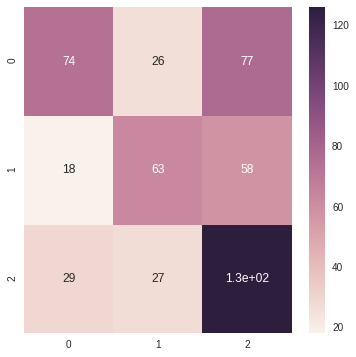

In [73]:
conf_matrix_meth02 = confusion_matrix(y_true, y_pred2)
fig = plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix_meth02, annot=True)

In [74]:
list_tweet_pos_correct3 = [y_pred2[i] for i in range(len(y_pred2)) if (y_pred2[i]==1 and y_pred2[i]*y_true[i]==1)]
print('le nombre de tweets positifs prédits correctement est de : ',len(list_tweet_pos_correct3))


le nombre de tweets positifs prédits correctement est de :  126


In [75]:
print('le nombre de tweets mal prédits est:', N - sum(y_pred2==y_true))

le nombre de tweets mal prédits est: 235


## 1.5 Test d'un autre algorithme

On reprend le travail fait en MDI343 avec l'implémentation du Naive Bayes.

In [76]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


In [77]:
path_stop = './english.stop'
stop_words = open(path_stop).read().split('\n')
print(stop_words)
print('========================================')
print('taille de la liste stop_words:', len(stop_words))

['a', "a's", 'able', 'about', 'above', 'according', 'accordingly', 'across', 'actually', 'after', 'afterwards', 'again', 'against', "ain't", 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'appear', 'appreciate', 'appropriate', 'are', "aren't", 'around', 'as', 'aside', 'ask', 'asking', 'associated', 'at', 'available', 'away', 'awfully', 'b', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'both', 'brief', 'but', 'by', 'c', "c'mon", "c's", 'came', 'can', "can't", 'cannot', 'cant', 'cause', 'causes', 'certain', 'certainly', 'changes', 'clearly', 'co', 'com', 'come', 'comes', 'concerning', 'consequently', 'consider', 'considering', 'contain', 'containing', 'conta

In [78]:
words_nostop = []
for tweet in wordsnoslang2:
    for t in tweet:
        if t.lower in stop_words:
            tweet.remove(t)
    words_nostop.append(tweet)
print(words_nostop)            
    

[['stellargirl', 'I', 'love', 'my', 'Kindle2', 'Not', 'that', 'the', 'DX', 'is', 'cool', 'but', 'the', '2', 'is', 'fantastic', 'in', 'its', 'own', 'right'], ['Reading', 'my', 'kindle2', 'Love', 'it', 'Lee', 'childs', 'is', 'good', 'read'], ['Ok', 'first', 'assesment', 'of', 'the', 'it', 'fucking', 'rocks'], ['kenburbary', 'You', 'll', 'love', 'your', 'Kindle2', 'I', 've', 'had', 'mine', 'for', 'a', 'few', 'months', 'and', 'never', 'looked', 'back', 'The', 'new', 'big', 'one', 'is', 'huge', 'No', 'need', 'for', 'remorse'], ['mikefish', 'Fair', 'enough', 'But', 'i', 'have', 'the', 'Kindle2', 'and', 'I', 'think', 'it', 's', 'perfect'], ['richardebaker', 'no', 'it', 'is', 'too', 'big', 'I', 'm', 'quite', 'happy', 'with', 'the', 'Kindle2'], ['Fuck', 'this', 'economy', 'I', 'hate', 'aig', 'and', 'their', 'non', 'loan', 'given', 'asses'], ['Jquery', 'is', 'my', 'new', 'best', 'friend'], ['Loves', 'twitter'], ['how', 'can', 'you', 'not', 'love', 'Obama', 'he', 'makes', 'jokes', 'about', 'himse

In [83]:
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk import word_tokenize,sent_tokenize
from sklearn.cross_validation import train_test_split

/home/audrey/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [80]:
def token_tag(list_token):
    list_to_keep =['JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'RB', ' RBR',
                'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    all_tag = []
    all_words = []
    for i in range(len(list_token)):
        words_tag = []
        ttag = tag(list_token[i])
        for t in ttag:
            if t[1] in list_to_keep:
                all_tag.append(ttag)
                words_tag.append(t[0])
        s = ' '.join(words_tag)
        all_words.append(s)
    return all_tag, all_words


In [81]:
all_tag, all_words = token_tag(wordsnoslang2)
print(all_words)

['stellargirl love Kindle2 Not DX is cool is fantastic own right', 'Reading kindle2 Love Lee childs is good read', 'Ok first assesment fucking rocks', 'kenburbary ll love Kindle2 ve had mine few months never looked new big one is huge No need remorse', 'mikefish Fair enough i have Kindle2 think s perfect', 'richardebaker is too big m quite happy Kindle2', 'Fuck economy hate aig non loan given asses', 'Jquery is new best friend', 'Loves twitter', 'can not love Obama makes jokes', 'Check video out President Obama White House Correspondents Dinner', 'Karoli firmly believe Obama/Pelosi have ZERO desire be civil s charade slogan want destroy conservatism', 'House Correspondents dinner was last night whoopi barbara sherri went Obama got standing ovation', 'Watchin Espn Jus seen new Nike Commerical Puppet Lebron shit was hilarious laugh my ass off', 'dear stop flywire shit is waste science ugly love vincentx24x', 'best athlete generation not time basketball related don t want get inter-sport 

In [84]:
X_train, X_test, y_train, y_test = train_test_split(all_words, y_true, train_size=0.8, random_state=42)

In [90]:
pipeline_pos = Pipeline([('vectorizer', CountVectorizer()), ('nb_sk', MultinomialNB())])

scores_pos = cross_val_score(pipeline_pos, X_train, y_train, cv=5)
pipeline_pos.fit(X_train, y_train)
y_pred3 = pipeline_pos.predict(X_test)
print(scores_pos)
print(' ')
print('la moyenne des scores obtenus par cross_validation sur le train est:', scores_pos.mean())
print('la déviation standard sur le train est:', scores_pos.std())
print(' ')
print(classification_report(y_test,y_pred3))


[ 0.61728395  0.675       0.73417722  0.67088608  0.6835443 ]
 
la moyenne des scores obtenus par cross_validation sur le train est: 0.676178309111
la déviation standard sur le train est: 0.0371915920354
 
             precision    recall  f1-score   support

         -1       0.47      0.65      0.55        26
          0       0.73      0.32      0.45        34
          1       0.63      0.78      0.70        40

avg / total       0.63      0.59      0.57       100



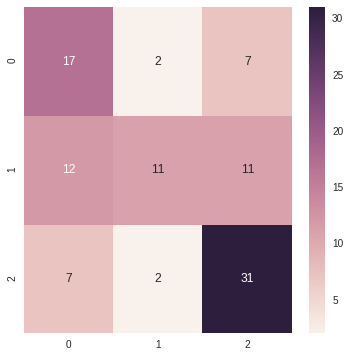

In [92]:
conf_matrix_meth03 = confusion_matrix(y_test, y_pred3)
fig = plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix_meth03, annot=True)

**Conclusion**: Ici, un simple Naïve Bayes est bien meilleur pour classer les tweets par rapport aux méthodes vues précédemment.  
On aurait pu également utiliser TFIDF dans ce dernier cas.  
Pour les premières methodes avec Sentiword, il serait possible d'utiliser la distance de Levenshtein pour choisir correctement le bon score d'un mot (par exemple pour I, il est proposé en premier choix Iodine et non le pronom).
